In [1]:
google_colab = False

# Google Colab用事前準備

In [2]:
# install
try:
    import binarybrain as bb
except:
    if google_colab and False:
        !pip install pybind11
        %cd /content
        !nvcc -V
        !sudo rm -fr BinaryBrain
        !rm -fr BinaryBrain
        !git clone --recursive -b ver3_develop https://github.com/ryuz/BinaryBrain.git
        %cd /content/BinaryBrain/python
        !sh copy_src.sh
        !python3 setup.py build
        !python3 setup.py develop

        import binarybrain as bb

In [3]:
# mount
if google_colab:
  from google.colab import drive 
  drive.mount('/content/drive')
  %cd /content/drive/My Drive/git-work/BinaryBrain_ver3_develop/tests/python

In [4]:
device = 0

import binarybrain as bb

import importlib
importlib.reload(bb)

bb.set_device(device)
prop = bb.get_device_properties(device)
print(prop)


name                     : GeForce GTX 1660 SUPER
totalGlobalMem           : 6442450944
sharedMemPerBlock        : 49152
regsPerBlock             : 65536
warpSize                 : 32
memPitch                 : 2147483647
maxThreadsPerBlock       : 1024
maxThreadsDim[0]         : 1024
maxThreadsDim[1]         : 1024
maxThreadsDim[2]         : 64
maxGridSize[0]           : 2147483647
maxGridSize[1]           : 65535
maxGridSize[2]           : 65535
clockRate                : 1800000
totalConstMem            : 65536
major                    : 7
minor                    : 5
textureAlignment         : 512
deviceOverlap            : 1
multiProcessorCount      : 22
kernelExecTimeoutEnabled : 1
integrated               : 0
canMapHostMemory         : 1
computeMode              : 0




# メインコード

In [5]:
import binarybrain as bb
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import os
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import OrderedDict

In [6]:
def make_test_image(src_x, src_t):
    dst_x = np.ndarray((len(src_x),  1, 28, 28), dtype=np.float32)
    dst_t = np.ndarray((len(src_x), 11, 28, 28), dtype=np.float32)
    for i in range(len(src_x)):
        x_img = src_x[i].copy()
        t_img = np.zeros((11, 28*28), dtype=np.float32)
        mask0 = x_img <= 0.5
        mask1 = x_img > 0.5
        for j in range(10):
          t_img[j,mask1] = src_t[i][j]
        t_img[10,mask0] = 0.15
        dst_x[i] = x_img.reshape(1, 28, 28)
        dst_t[i] = t_img.reshape(11, 28, 28)
    return dst_x, dst_t

In [7]:
def make_test_data(src_x, src_t):
    x, t = make_test_image(src_x, src_t)

    dst_x = np.ndarray((len(src_x) // 4,  1*56*56), dtype=np.float32)
    dst_t = np.ndarray((len(src_x) // 4, 11*56*56), dtype=np.float32)
    for i in range(len(x) // 4):
        x_img = np.hstack((np.dstack((x[i*4+0], x[i*4+1])), np.dstack((x[i*4+2], x[i*4+3]))))
        t_img = np.hstack((np.dstack((t[i*4+0], t[i*4+1])), np.dstack((t[i*4+2], t[i*4+3]))))
        dst_x[i] = x_img.reshape(-1)
        dst_t[i] = t_img.reshape(-1)
    return dst_x, dst_t

In [8]:
def image_transform(img):
    angle = random.uniform(-10.0, +10.0)
    scale = random.uniform(0.8, 1.1)
    trans = cv2.getRotationMatrix2D((14, 14), angle , scale)
    trans[0][2] += random.uniform(-2.0, 2.0)
    trans[1][2] += random.uniform(-2.0, 2.0)
    return cv2.warpAffine(img.reshape(28, 28), trans, (28, 28))

def make_td_image(src_x, src_t, w=28, h=28, depth=27):
    l = len(src_x)
    mx = (28 + depth + w + depth + 27) // 28
    my = (28 + depth + h + depth + 27) // 28
    dst_x = np.zeros(( 1, 28*my, 28*mx), dtype=np.float32)
    dst_t = np.zeros((11, 28*my, 28*mx), dtype=np.float32)
    for y in range(my):
        for x in range(mx):
            i = random.randrange(0, l)
            dst_x[0,y*28:y*28+28, x*28:x*28+28] = image_transform(src_x[i])
            dst_t[0:10,y*28:y*28+28, x*28:x*28+28] = np.tile(src_t[i], (28,28)).reshape(28, 28, 10).transpose(2, 0, 1)
    x_flag0 = dst_x[0] <= 0.5
    x_flag1 = dst_x[0] >  0.5
    for i in range(10):
        dst_t[i][x_flag0] = 0
    dst_t[10][x_flag0] = 0.15
    
    xs = random.randrange(0, 28)
    ys = random.randrange(0, 28)
    dst_x  = dst_x[:,ys:ys+2*depth+h,xs:xs+2*depth+w]
    x_flag = x_flag1[ys:ys+2*depth+h,xs:xs+2*depth+w]
    
    dst_t  = dst_t[:,ys+depth:ys+depth+h,xs+depth:xs+depth+w]
    t_flag = x_flag1[ys+depth:ys+depth+h,xs+depth:xs+depth+w]
    
    x_mask = np.zeros(x_flag.shape, dtype=np.float32)
    x_mask[x_flag] = 1.0
    t_mask = np.zeros(t_flag.shape, dtype=np.float32)
    t_mask[t_flag] = 1.0
    return dst_x.flatten(), dst_t.flatten(), x_mask.flatten(), t_mask.flatten()

def generate_td(src_td, train_size=60000//4, test_size=10000//4, w=28, h=28, depth=27):
    dst_td = {}
    
    dst_td['x_train']      = []
    dst_td['t_train']      = []
    dst_td['x_mask_train'] = []
    dst_td['t_mask_train'] = []
    for _ in tqdm(range(train_size)):
        x, t, xm, tm = make_td_image(src_td['x_train'], src_td['t_train'], w=w, h=h, depth=depth)
        dst_td['x_train'].append(x)
        dst_td['t_train'].append(t)
        dst_td['x_mask_train'].append(xm)
        dst_td['t_mask_train'].append(tm)
    dst_td['x_train']      = np.array(dst_td['x_train'])
    dst_td['t_train']      = np.array(dst_td['t_train'])
    dst_td['x_mask_train'] = np.array(dst_td['x_mask_train'])
    dst_td['t_mask_train'] = np.array(dst_td['t_mask_train'])
    
    dst_td['x_test']      = []
    dst_td['t_test']      = []
    dst_td['x_mask_test'] = []
    dst_td['t_mask_test'] = []
    for _ in tqdm(range(test_size)):
        x, t, xm, tm = make_td_image(src_td['x_test'], src_td['t_test'], w=w, h=h, depth=depth)
        dst_td['x_test'].append(x)
        dst_td['t_test'].append(t)
        dst_td['x_mask_test'].append(xm)
        dst_td['t_mask_test'].append(tm)
    dst_td['x_test']      = np.array(dst_td['x_test'])
    dst_td['t_test']      = np.array(dst_td['t_test'])
    dst_td['x_mask_test'] = np.array(dst_td['x_mask_test'])
    dst_td['t_mask_test'] = np.array(dst_td['t_mask_test'])
    
    dst_td['x_shape'] = [depth*2+w, depth*2+h, 1]
    dst_td['t_shape'] = [w, h, 11]
    
    return dst_td

In [9]:
# load MNIST data
src_td = bb.load_mnist()

In [10]:
# 設定
layer_depth = 27
t_width     = 28*2
t_height    = 28*2

In [11]:
td = generate_td(src_td, w=t_width, h=t_height, depth=layer_depth)

100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:05<00:00, 444.82it/s]


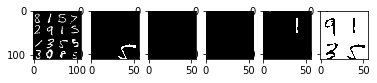

In [12]:
plt.subplot(161)
plt.imshow(td['x_train'][0].reshape(layer_depth*2+56, layer_depth*2+56), 'gray')
plt.subplot(162)
plt.imshow(td['t_train'][0].reshape(11, 56, 56)[5], 'gray')
plt.subplot(163)
plt.imshow(td['t_train'][0].reshape(11, 56, 56)[0], 'gray')
plt.subplot(164)
plt.imshow(td['t_train'][0].reshape(11, 56, 56)[4], 'gray')
plt.subplot(165)
plt.imshow(td['t_train'][0].reshape(11, 56, 56)[1], 'gray')
plt.subplot(166)
plt.imshow(td['t_train'][0].reshape(11, 56, 56)[10], 'gray')

In [13]:
color_table = [
    [0xe6, 0x00, 0x12],  # 0
    [0x92, 0x07, 0x83],  # 1
    [0x1d, 0x20, 0x88],  # 2
    [0x00, 0x68, 0xb7],  # 3
    [0x00, 0xa0, 0xe9],  # 4
    [0x00, 0x9e, 0x96],  # 5
    [0x00, 0x99, 0x44],  # 6
    [0x8f, 0xc3, 0x1f],  # 7
    [0xff, 0xf1, 0x00],  # 8
    [0xf3, 0x98, 0x00],  # 9
    [0x00, 0x00, 0x00],  # BGC
]

def frame_to_image(frame):
    idx_img = np.argmax(frame, axis=0)
    rgb_img = np.ndarray((idx_img.shape[0], idx_img.shape[1], 3), dtype=np.uint8)
    for y in range(idx_img.shape[1]):
        for x in range(idx_img.shape[0]):
            rgb_img[y][x] = color_table[idx_img[y][x]]
    return rgb_img

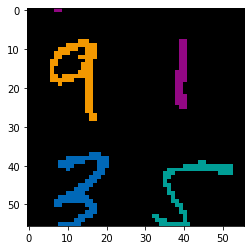

In [14]:
plt.imshow(frame_to_image(td['t_train'][0].reshape(11, 56, 56)))

# ネットワーク構築

In [15]:
data_path = 'MnistSegSparseCnnBinDistillationReverse'
os.makedirs(data_path, exist_ok=True)
network_name = 'mnist-seg-sparse-cnn-bin-distillation-reverse'

ref_affine_list = []
ref_norm_list   = []
target_lut_list = []

def clear_list():
    ref_affine_list.clear()
    ref_norm_list.clear()
    target_lut_list.clear()

def save_model_list(model_list, name, path='.'):
    os.makedirs(os.path.join(data_path, path), exist_ok=True)
    for i, model in enumerate(model_list):
        model.save_json(os.path.join(data_path, path, '%s_%d.json' % (name, i)))

def load_model_list(model_list, name, path='.'):
    for i, model in enumerate(model_list):
        filename = os.path.join(data_path, path, '%s_%d.json' % (name, i))
        if not os.path.exists(filename):
            return False
        model.load_json(filename)
    return True

def save_all_model(path='.'):
    save_model_list(ref_affine_list, 'ref_affine',    path)
    save_model_list(ref_norm_list,   'ref_norm_list', path)
    save_model_list(target_lut_list, 'target_lut',    path)
    
def load_all_model(path='.'):
    if not load_model_list(ref_affine_list, 'ref_affine',    path): return False
    if not load_model_list(ref_norm_list,   'ref_norm_list', path): return False
    if not load_model_list(target_lut_list, 'target_lut',    path): return False
    return True

def make_common_layer(model):
    layer = {}
    layer['type']   = 'common'
    layer['select'] = 'common'
    layer['common'] = model
    return layer    

def make_cnv_layer(ch_size, w=3, h=3, lut_size=2, bn=True, connection='random', padding='valid'):
    # setup infomation
    layer = {}
    layer['type']            = 'convolution'
    layer['select']          = 'ref'
    layer['connection']      = connection
    layer['target_lut_size'] = 2
    
    layer['ref_affine'] = bb.DenseAffine.create([ch_size])
    layer['ref_norm']   = bb.BatchNormalization.create()
    layer['ref_act']    = bb.BinarizeBit.create()
    
    layer['lut_size'] = lut_size
    for i in range(lut_size):
        layer['target_lut%d' % i] = bb.SparseLut6Bit.create([ch_size*(6**i)], bn)
    
    # save
    ref_affine_list.append(layer['ref_affine'])
    ref_norm_list.append(layer['ref_norm'])
    for i in range(lut_size-1, -1, -1):
        target_lut_list.append(layer['target_lut%d' % i])
    
    # make network
    ref_subnet =  bb.Sequential.create()
    ref_subnet.add(layer['ref_affine'])
    ref_subnet.add(layer['ref_norm'])
    ref_subnet.add(layer['ref_act'])
    layer['ref'] = bb.LoweringConvolutionBit.create(ref_subnet, w, h, 1, 1, padding=padding)
    
    target_subnet = bb.Sequential.create()
    for i in range(lut_size-1, -1, -1):
        target_subnet.add(layer['target_lut%d' % i])
    layer['target'] = bb.LoweringConvolutionBit.create(target_subnet, w, h, 1, 1, padding=padding)
    
    return layer

def build_net(layer_list):
    net = bb.Sequential.create()
    for layer in layer_list:
        net.add(layer[layer['select']])
    return net

In [16]:
# build network
modulation_size = 1
layer_rel2bin = bb.RealToBinaryBit.create(modulation_size, framewise=True)
layer_bin2rel = bb.BinaryToRealBit.create(modulation_size)

clear_list()
layer_list = []
layer_list.append(make_common_layer(layer_rel2bin))
for _ in range(27):
    layer_list.append(make_cnv_layer(32, 3, 3))
layer_list.append(make_cnv_layer(11, 1, 1, 2, False))
layer_list.append(make_common_layer(layer_bin2rel))

In [17]:
main_net = build_net(layer_list)
main_net.set_input_shape(td['x_shape'])
main_net.send_command('binary true')

In [18]:
for layer in layer_list:
    if layer['type'] != 'common':
        layer['target'].set_input_shape(layer['ref'].get_input_shape())

In [19]:
def plot_image(net, td):
    x_buf = bb.FrameBuffer()
    x_buf.resize(16, td['x_shape'])
    x_buf.set_data(td['x_test'][0:16])
    y_buf = net.forward(x_buf, False)

    data = y_buf.get_data(0)
    
    plt.subplot(141)
    frame = np.array(data[0]).reshape(56, 56, -1)
    plt.imshow(frame_to_image(frame.reshape(11, 56, 56)))
    
    plt.subplot(142)
    frame = np.array(data[1]).reshape(56, 56, -1)
    plt.imshow(frame_to_image(frame.reshape(11, 56, 56)))

    plt.subplot(143)
    frame = np.array(data[2]).reshape(56, 56, -1)
    plt.imshow(frame_to_image(frame.reshape(11, 56, 56)))

    plt.subplot(144)
    frame = np.array(data[3]).reshape(56, 56, -1)
    plt.imshow(frame_to_image(frame.reshape(11, 56, 56)))

    plt.show()

----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [DenseAffine] 
       input  shape : {3, 3, 1}       output shape : {32}
      ----------------------------------------------------------------
      [BatchNormalization] 
       input  shape : {32}       output shape : {32}
      -----------------------

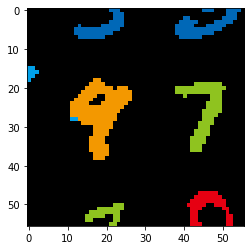

epoch=1 test_accuracy=0.443801 test_loss=4870.259508 train_accuracy=0.437790 train_loss=4872.668984


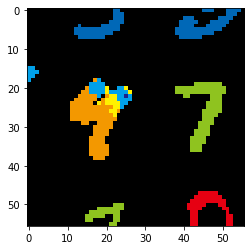

In [20]:
loaded = load_all_model('base2')
#if not loaded:
if True:
    print(main_net.get_info())
    plot_image(main_net, td)
    
    # train
    loss      = bb.LossSoftmaxCrossEntropy.create()
    metrics   = bb.MetricsCategoricalAccuracy.create()
    optimizer = bb.OptimizerAdam.create()
    optimizer.set_variables(main_net.get_parameters(), main_net.get_gradients())
    
    runner = bb.Runner(main_net, network_name, loss, metrics, optimizer)
    runner.fitting(td, epoch_size=1, mini_batch_size=32, file_write=False, file_read=False)

    save_all_model('base2')
    plot_image(main_net, td)
    
else:
    print('OK')

In [20]:
for layer in layer_list:
    if layer['type'] != 'common':
        layer['target'].set_input_shape(layer['ref'].get_input_shape())

In [21]:
#save_all_model('base')

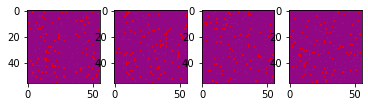

In [22]:
plot_image(main_net, td)

In [21]:
def distillation_layer(layer):
    if layer['type'] != 'convolution':
        return False
    
    if layer['lut_size'] == 2:
        ref_affine  = layer['ref_affine']
        target_lut0 = layer['target_lut0']
        target_lut1 = layer['target_lut1']

        tensorW = layer['ref_affine'].W()
        W = np.array(tensorW.get_data()).reshape(tensorW.get_shape()[::-1])
        idx = np.argsort(-np.abs(W), axis=1)
        
        print(idx.shape)
        
        # Weight順で接続
        lut0_input_node_size  = target_lut0.get_input_node_size()
        lut0_output_node_size = target_lut0.get_output_node_size()
        for i in range(lut0_output_node_size):
            for j in range(6):
                target_lut0.set_connection_index([i], j, (i*6+j) % lut0_input_node_size)

        lut1_input_node_size  = target_lut1.get_input_node_size()
        lut1_output_node_size = target_lut1.get_output_node_size()
        for i in range(lut0_output_node_size):
            for j in range(6):
                for k in range(6):
                    target_lut1.set_connection_index([i*6+j], k, idx[i][(j*6+k) % lut1_input_node_size])
    
    layer['select'] = 'target'
    return True

In [22]:
distillation_layer(layer_list[28])

main_net = build_net(layer_list)
main_net.set_input_shape(td['x_shape'])
main_net.send_command('binary true')

print(main_net.get_info())

(11, 32)
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [DenseAffine] 
       input  shape : {3, 3, 1}       output shape : {32}
      ----------------------------------------------------------------
      [BatchNormalization] 
       input  shape : {32}       output shape : {32}
      --------------

epoch=1 test_accuracy=0.368098 test_loss=4937.889351 train_accuracy=0.359548 train_loss=4941.963618


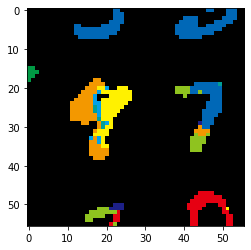

epoch=1 test_accuracy=0.401086 test_loss=4913.473562 train_accuracy=0.394707 train_loss=4915.842648


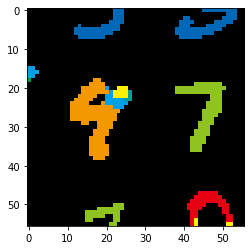

epoch=1 test_accuracy=0.461142 test_loss=4873.761727 train_accuracy=0.456573 train_loss=4875.709191


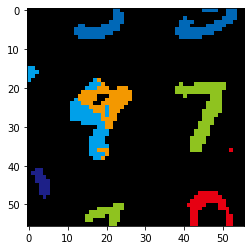

epoch=1 test_accuracy=0.463965 test_loss=4866.005461 train_accuracy=0.459644 train_loss=4867.086702


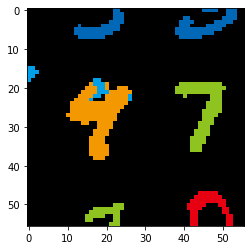

In [26]:
main_net.send_command('parameter_lock false')
layer_list[28]['target'].send_command('parameter_lock false')

loss      = bb.LossSoftmaxCrossEntropy.create()
metrics   = bb.MetricsCategoricalAccuracy.create()
optimizer = bb.OptimizerAdam.create()
optimizer.set_variables(main_net.get_parameters(), main_net.get_gradients())

for i in range(4):
    runner = bb.Runner(main_net, network_name, loss, metrics, optimizer)
    runner.fitting(td, epoch_size=1, mini_batch_size=32, file_write=False, file_read=False)
    save_all_model('028_f%02d' % i)
    plot_image(main_net, td)

In [26]:
load_all_model('027')
distillation_layer(layer_list[28])
distillation_layer(layer_list[27])
main_net = build_net(layer_list)
main_net.set_input_shape(td['x_shape'])
main_net.send_command('binary true')
print(main_net.get_info())

(11, 32)
(32, 288)
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [DenseAffine] 
       input  shape : {3, 3, 1}       output shape : {32}
      ----------------------------------------------------------------
      [BatchNormalization] 
       input  shape : {32}       output shape : {32}
      ----

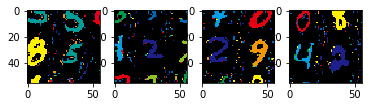

In [27]:
plot_image(main_net, td)

epoch=1 test_accuracy=0.462335 test_loss=4912.159954 train_accuracy=0.458559 train_loss=4912.595639


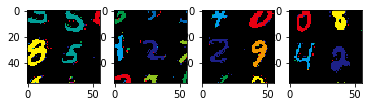

In [29]:
main_net.send_command('parameter_lock false')
loss      = bb.LossSoftmaxCrossEntropy.create()
metrics   = bb.MetricsCategoricalAccuracy.create()
optimizer = bb.OptimizerAdam.create()
optimizer.set_variables(main_net.get_parameters(), main_net.get_gradients())
runner = bb.Runner(main_net, network_name, loss, metrics, optimizer)
runner.fitting(td, epoch_size=1, mini_batch_size=32, file_write=False, file_read=False)
save_all_model('027f')
plot_image(main_net, td)

(32, 288)
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [DenseAffine] 
       input  shape : {3, 3, 1}       output shape : {32}
      ----------------------------------------------------------------
      [BatchNormalization] 
       input  shape : {32}       output shape : {32}
      -------------

(32, 288)
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [DenseAffine] 
       input  shape : {3, 3, 1}       output shape : {32}
      ----------------------------------------------------------------
      [BatchNormalization] 
       input  shape : {32}       output shape : {32}
      -------------

(32, 288)
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [DenseAffine] 
       input  shape : {3, 3, 1}       output shape : {32}
      ----------------------------------------------------------------
      [BatchNormalization] 
       input  shape : {32}       output shape : {32}
      -------------

(32, 288)
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [DenseAffine] 
       input  shape : {3, 3, 1}       output shape : {32}
      ----------------------------------------------------------------
      [BatchNormalization] 
       input  shape : {32}       output shape : {32}
      -------------

(32, 288)
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [DenseAffine] 
       input  shape : {3, 3, 1}       output shape : {32}
      ----------------------------------------------------------------
      [BatchNormalization] 
       input  shape : {32}       output shape : {32}
      -------------

(32, 288)
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [DenseAffine] 
       input  shape : {3, 3, 1}       output shape : {32}
      ----------------------------------------------------------------
      [BatchNormalization] 
       input  shape : {32}       output shape : {32}
      -------------

(32, 288)
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [DenseAffine] 
       input  shape : {3, 3, 1}       output shape : {32}
      ----------------------------------------------------------------
      [BatchNormalization] 
       input  shape : {32}       output shape : {32}
      -------------

(32, 288)
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [DenseAffine] 
       input  shape : {3, 3, 1}       output shape : {32}
      ----------------------------------------------------------------
      [BatchNormalization] 
       input  shape : {32}       output shape : {32}
      -------------

epoch=1 test_accuracy=0.349655 test_loss=4988.798786 train_accuracy=0.344559 train_loss=4990.415588


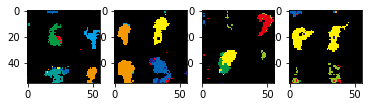

epoch=1 test_accuracy=0.333979 test_loss=4994.964752 train_accuracy=0.329451 train_loss=4996.321079


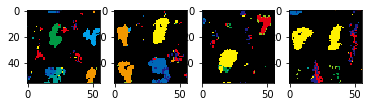

epoch=1 test_accuracy=0.339293 test_loss=4987.823936 train_accuracy=0.334382 train_loss=4989.504599


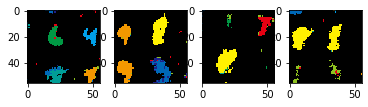

epoch=1 test_accuracy=0.316485 test_loss=4992.934509 train_accuracy=0.311697 train_loss=4994.645709


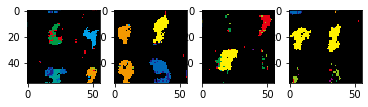

(32, 288)
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [DenseAffine] 
       input  shape : {3, 3, 1}       output shape : {32}
      ----------------------------------------------------------------
      [BatchNormalization] 
       input  shape : {32}       output shape : {32}
      -------------

epoch=1 test_accuracy=0.319726 test_loss=5000.293310 train_accuracy=0.314856 train_loss=5001.829719


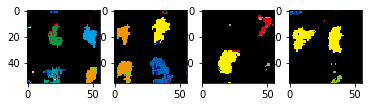

epoch=1 test_accuracy=0.312685 test_loss=5001.195359 train_accuracy=0.307101 train_loss=5003.053644


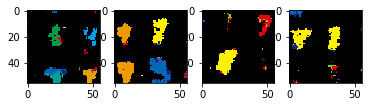

epoch=1 test_accuracy=0.313054 test_loss=5000.703395 train_accuracy=0.308426 train_loss=5002.258713


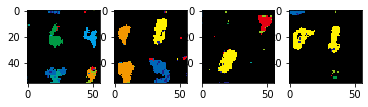

epoch=1 test_accuracy=0.316398 test_loss=5006.808740 train_accuracy=0.312480 train_loss=5008.124092


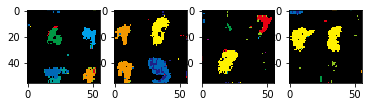

(32, 288)
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [DenseAffine] 
       input  shape : {3, 3, 1}       output shape : {32}
      ----------------------------------------------------------------
      [BatchNormalization] 
       input  shape : {32}       output shape : {32}
      -------------

epoch=1 test_accuracy=0.262262 test_loss=5027.338492 train_accuracy=0.257684 train_loss=5028.837851


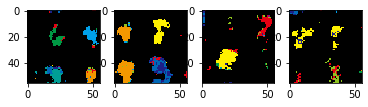

epoch=1 test_accuracy=0.292232 test_loss=5017.981717 train_accuracy=0.287908 train_loss=5019.428070


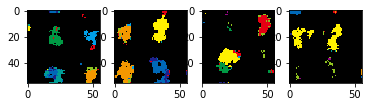

epoch=1 test_accuracy=0.298285 test_loss=5018.847421 train_accuracy=0.293261 train_loss=5020.679724


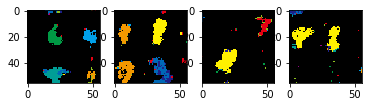

epoch=1 test_accuracy=0.296873 test_loss=5014.876102 train_accuracy=0.292136 train_loss=5016.299386


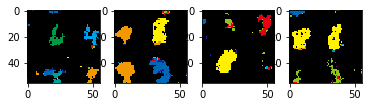

(32, 288)
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [DenseAffine] 
       input  shape : {3, 3, 1}       output shape : {32}
      ----------------------------------------------------------------
      [BatchNormalization] 
       input  shape : {32}       output shape : {32}
      -------------

epoch=1 test_accuracy=0.256456 test_loss=5035.817244 train_accuracy=0.252209 train_loss=5037.032951


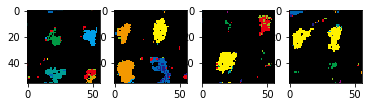

epoch=1 test_accuracy=0.299749 test_loss=5032.084591 train_accuracy=0.294639 train_loss=5033.326002


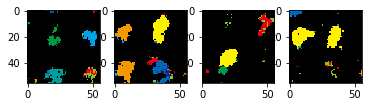

epoch=1 test_accuracy=0.279401 test_loss=5025.745873 train_accuracy=0.274469 train_loss=5027.512591


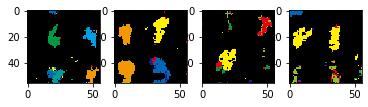

epoch=1 test_accuracy=0.303801 test_loss=5024.070431 train_accuracy=0.299407 train_loss=5025.541873


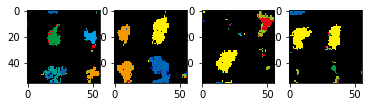

(32, 288)
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [DenseAffine] 
       input  shape : {3, 3, 1}       output shape : {32}
      ----------------------------------------------------------------
      [BatchNormalization] 
       input  shape : {32}       output shape : {32}
      -------------

epoch=1 test_accuracy=0.266440 test_loss=5041.351622 train_accuracy=0.262493 train_loss=5042.546770


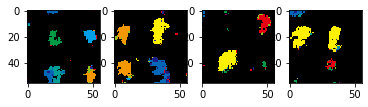

epoch=1 test_accuracy=0.268126 test_loss=5040.305772 train_accuracy=0.263390 train_loss=5041.882388


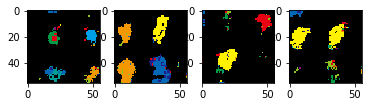

epoch=1 test_accuracy=0.276722 test_loss=5038.062384 train_accuracy=0.273316 train_loss=5038.904193


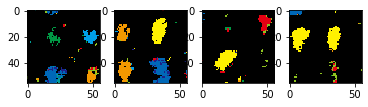

epoch=1 test_accuracy=0.243824 test_loss=5055.365573 train_accuracy=0.239254 train_loss=5057.301321


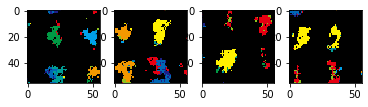

(32, 288)
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [DenseAffine] 
       input  shape : {3, 3, 1}       output shape : {32}
      ----------------------------------------------------------------
      [BatchNormalization] 
       input  shape : {32}       output shape : {32}
      -------------

epoch=1 test_accuracy=0.256746 test_loss=5058.459491 train_accuracy=0.252477 train_loss=5059.638373


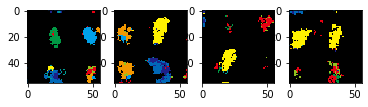

epoch=1 test_accuracy=0.227320 test_loss=5069.287337 train_accuracy=0.222553 train_loss=5071.030135


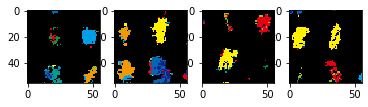

epoch=1 test_accuracy=0.220607 test_loss=5079.245432 train_accuracy=0.217174 train_loss=5080.040714


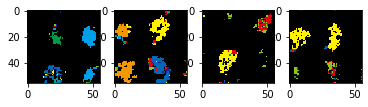

epoch=1 test_accuracy=0.249653 test_loss=5067.103807 train_accuracy=0.243975 train_loss=5069.389445


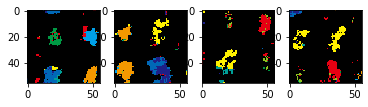

(32, 288)
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [DenseAffine] 
       input  shape : {3, 3, 1}       output shape : {32}
      ----------------------------------------------------------------
      [BatchNormalization] 
       input  shape : {32}       output shape : {32}
      -------------

epoch=1 test_accuracy=0.232815 test_loss=5076.199376 train_accuracy=0.228802 train_loss=5077.168737


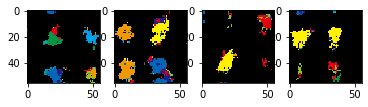

epoch=1 test_accuracy=0.216431 test_loss=5089.017397 train_accuracy=0.212351 train_loss=5089.939236


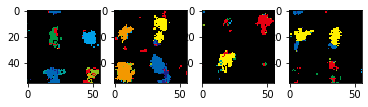

epoch=1 test_accuracy=0.219515 test_loss=5081.802211 train_accuracy=0.215446 train_loss=5082.860804


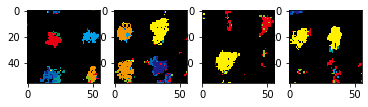

epoch=1 test_accuracy=0.230769 test_loss=5075.281831 train_accuracy=0.226861 train_loss=5076.291450


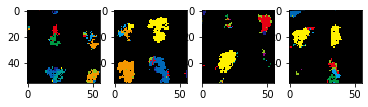

(32, 288)
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [DenseAffine] 
       input  shape : {3, 3, 1}       output shape : {32}
      ----------------------------------------------------------------
      [BatchNormalization] 
       input  shape : {32}       output shape : {32}
      -------------

epoch=1 test_accuracy=0.225521 test_loss=5091.876738 train_accuracy=0.222652 train_loss=5091.552755


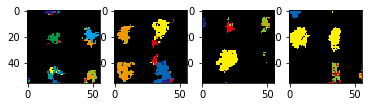

epoch=1 test_accuracy=0.211026 test_loss=5096.177781 train_accuracy=0.206861 train_loss=5097.237601


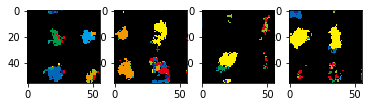

epoch=1 test_accuracy=0.200242 test_loss=5104.411401 train_accuracy=0.196735 train_loss=5105.802685


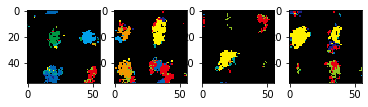

epoch=1 test_accuracy=0.210499 test_loss=5100.095901 train_accuracy=0.205502 train_loss=5101.188415


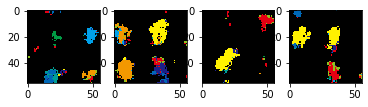

(32, 288)
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [DenseAffine] 
       input  shape : {3, 3, 1}       output shape : {32}
      ----------------------------------------------------------------
      [BatchNormalization] 
       input  shape : {32}       output shape : {32}
      -------------

epoch=1 test_accuracy=0.162284 test_loss=5128.925800 train_accuracy=0.159020 train_loss=5128.957471


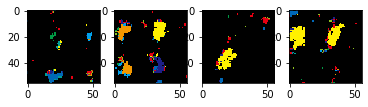

epoch=1 test_accuracy=0.173383 test_loss=5119.294861 train_accuracy=0.169781 train_loss=5119.818685


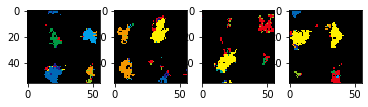

epoch=1 test_accuracy=0.187944 test_loss=5115.341848 train_accuracy=0.184380 train_loss=5115.673640


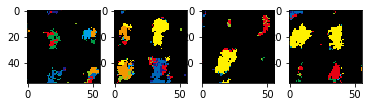

epoch=1 test_accuracy=0.182559 test_loss=5120.592142 train_accuracy=0.180938 train_loss=5120.143875


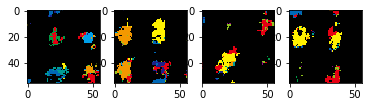

(32, 288)
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [DenseAffine] 
       input  shape : {3, 3, 1}       output shape : {32}
      ----------------------------------------------------------------
      [BatchNormalization] 
       input  shape : {32}       output shape : {32}
      -------------

epoch=1 test_accuracy=0.150347 test_loss=5143.293051 train_accuracy=0.147739 train_loss=5143.395327


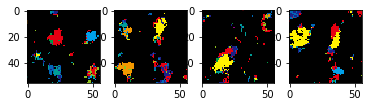

epoch=1 test_accuracy=0.177825 test_loss=5128.976579 train_accuracy=0.174982 train_loss=5129.328280


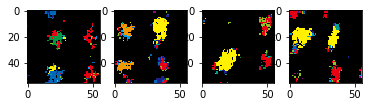

epoch=1 test_accuracy=0.179640 test_loss=5126.017164 train_accuracy=0.177154 train_loss=5125.944642


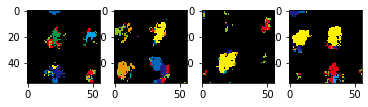

epoch=1 test_accuracy=0.139216 test_loss=5148.759477 train_accuracy=0.137506 train_loss=5147.852124


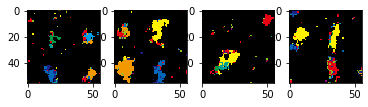

(32, 288)
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [DenseAffine] 
       input  shape : {3, 3, 1}       output shape : {32}
      ----------------------------------------------------------------
      [BatchNormalization] 
       input  shape : {32}       output shape : {32}
      -------------

epoch=1 test_accuracy=0.142383 test_loss=5154.093994 train_accuracy=0.140233 train_loss=5153.368246


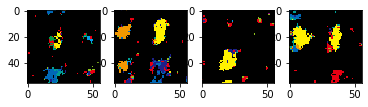

epoch=1 test_accuracy=0.177547 test_loss=5136.307925 train_accuracy=0.174394 train_loss=5136.216447


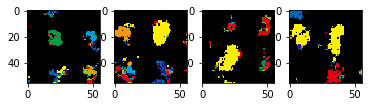

epoch=1 test_accuracy=0.153203 test_loss=5146.220268 train_accuracy=0.150778 train_loss=5145.703644


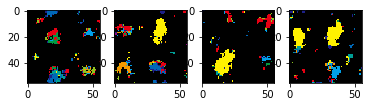

epoch=1 test_accuracy=0.169270 test_loss=5138.589003 train_accuracy=0.166765 train_loss=5138.279923


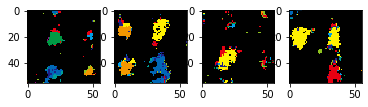

(32, 288)
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [DenseAffine] 
       input  shape : {3, 3, 1}       output shape : {32}
      ----------------------------------------------------------------
      [BatchNormalization] 
       input  shape : {32}       output shape : {32}
      -------------

epoch=1 test_accuracy=0.159525 test_loss=5156.398045 train_accuracy=0.156266 train_loss=5156.060960


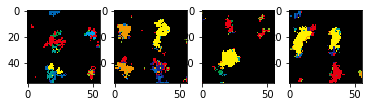

epoch=1 test_accuracy=0.127170 test_loss=5163.202451 train_accuracy=0.125804 train_loss=5161.386978


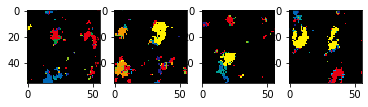

epoch=1 test_accuracy=0.142726 test_loss=5151.229191 train_accuracy=0.141971 train_loss=5149.525286


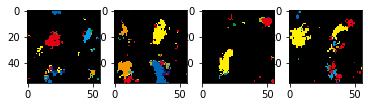

epoch=1 test_accuracy=0.133692 test_loss=5164.130844 train_accuracy=0.131599 train_loss=5163.593583


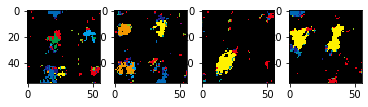

(32, 288)
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [DenseAffine] 
       input  shape : {3, 3, 1}       output shape : {32}
      ----------------------------------------------------------------
      [BatchNormalization] 
       input  shape : {32}       output shape : {32}
      -------------

epoch=1 test_accuracy=0.135519 test_loss=5166.752578 train_accuracy=0.134582 train_loss=5165.194854


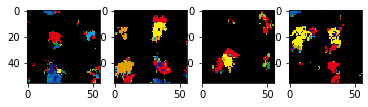

epoch=1 test_accuracy=0.131780 test_loss=5173.084156 train_accuracy=0.131295 train_loss=5170.903433


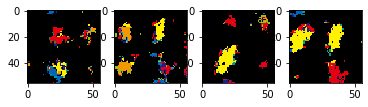

epoch=1 test_accuracy=0.146194 test_loss=5159.631840 train_accuracy=0.143329 train_loss=5159.769046


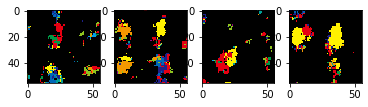

epoch=1 test_accuracy=0.126339 test_loss=5172.663560 train_accuracy=0.125102 train_loss=5171.851476


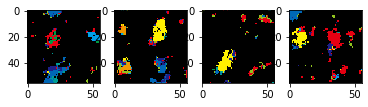

(32, 288)
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [DenseAffine] 
       input  shape : {3, 3, 1}       output shape : {32}
      ----------------------------------------------------------------
      [BatchNormalization] 
       input  shape : {32}       output shape : {32}
      -------------

epoch=1 test_accuracy=0.124627 test_loss=5165.764446 train_accuracy=0.122375 train_loss=5164.876793


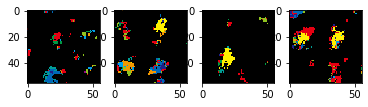

epoch=1 test_accuracy=0.127344 test_loss=5169.589276 train_accuracy=0.127132 train_loss=5167.322159


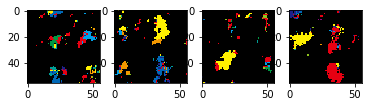

epoch=1 test_accuracy=0.125607 test_loss=5174.051050 train_accuracy=0.123945 train_loss=5172.506896


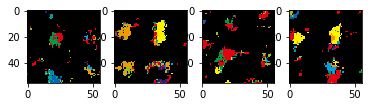

epoch=1 test_accuracy=0.136800 test_loss=5166.810860 train_accuracy=0.133890 train_loss=5166.842286


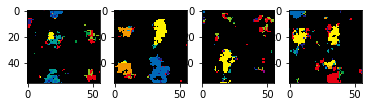

(32, 288)
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {110, 110, 1}   output shape : {110, 110, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {110, 110, 1}   output shape : {108, 108, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {110, 110, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [DenseAffine] 
       input  shape : {3, 3, 1}       output shape : {32}
      ----------------------------------------------------------------
      [BatchNormalization] 
       input  shape : {32}       output shape : {32}
      -------------

epoch=1 test_accuracy=0.132858 test_loss=5164.022770 train_accuracy=0.131836 train_loss=5162.590668


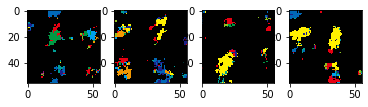

epoch=1 test_accuracy=0.144109 test_loss=5278.806750 train_accuracy=0.141988 train_loss=5277.575397


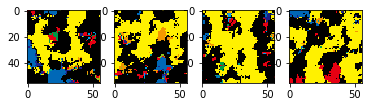

epoch=1 test_accuracy=0.087726 test_loss=5211.629126 train_accuracy=0.085235 train_loss=5210.826275


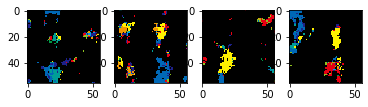

KeyboardInterrupt: 

In [23]:
for i in range(26, -1, -1):
    distillation_layer(layer_list[i])
    
    main_net = build_net(layer_list)
    main_net.set_input_shape(td['x_shape'])
    main_net.send_command('binary true')
    print(main_net.get_info())
    
    main_net.send_command('parameter_lock true')
    layer_list[i]['target'].send_command('parameter_lock false')

    loss      = bb.LossSoftmaxCrossEntropy.create()
    metrics   = bb.MetricsCategoricalAccuracy.create()
    optimizer = bb.OptimizerAdam.create()
    optimizer.set_variables(main_net.get_parameters(), main_net.get_gradients())
    
    if not load_all_model('%03d' % i):
        for j in range(2):
            runner = bb.Runner(main_net, network_name, loss, metrics, optimizer)
            runner.fitting(td, epoch_size=1, mini_batch_size=32, file_write=False, file_read=False)
            save_all_model('%03d' % i)
            plot_image(main_net, td)

        main_net.send_command('parameter_lock false')
    
    if not load_all_model('%03df' % i):
        for j in range(2):
            runner = bb.Runner(main_net, network_name, loss, metrics, optimizer)
            runner.fitting(td, epoch_size=1, mini_batch_size=32, file_write=False, file_read=False)
            save_all_model('%03df' % i)
            plot_image(main_net, td)


In [22]:
 for i in range(28):
    distillation_layer(layer_list[i])

(32, 9)
(32, 288)
(32, 288)
(32, 288)
(32, 288)
(32, 288)
(32, 288)
(32, 288)
(32, 288)
(32, 288)
(32, 288)
(32, 288)
(32, 288)
(32, 288)
(32, 288)
(32, 288)
(32, 288)
(32, 288)
(32, 288)
(32, 288)
(32, 288)
(32, 288)
(32, 288)
(32, 288)
(32, 288)
(32, 288)
(32, 288)


In [23]:
load_all_model('027')

True

In [24]:
distillation_layer(layer_list[28])

main_net = build_net(layer_list)
main_net.set_input_shape(td['x_shape'])
main_net.send_command('binary true')

print(main_net.get_info())

(11, 32)
----------------------------------------------------------------------
[Sequential] 
  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {56, 56, 1}   output shape : {56, 56, 1}
  --------------------------------------------------------------------
  [LoweringConvolution] 
   filter size : (3, 3)
   input  shape : {56, 56, 1}   output shape : {56, 56, 32}
    ------------------------------------------------------------------
    [ConvolutionIm2Col] 
     input  shape : {56, 56, 1}     output shape : {3, 3, 1}
    ------------------------------------------------------------------
    [Sequential] 
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {3, 3, 1}       output shape : {192}
       binary : 1       batch_norm : 1
      ----------------------------------------------------------------
      [SparseLut6] 
       input  shape : {192}       output shape : {32

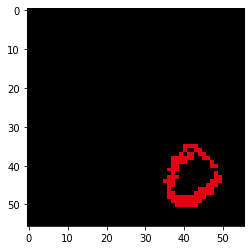

In [25]:
load_all_model('last1')
plot_image(main_net, td)

In [ ]:
main_net.send_command('parameter_lock false')
layer_list[28]['target'].send_command('parameter_lock false')
    
loss      = bb.LossSoftmaxCrossEntropy.create()
metrics   = bb.MetricsCategoricalAccuracy.create()
optimizer = bb.OptimizerAdam.create()
optimizer.set_variables(main_net.get_parameters(), main_net.get_gradients())

for i in range(4):
    runner = bb.Runner(main_net, network_name, loss, metrics, optimizer)
    runner.fitting(td, epoch_size=1, mini_batch_size=32, file_write=False, file_read=False)
    save_all_model('last_%d' % i)
    plot_image(main_net, td)

 27%|█████████████▎                                    | 125/469 [10:14<28:15,  4.93s/it, loss=5.15e+3, accuracy=0.895]

epoch=1 test_accuracy=0.806068 test_loss=5502.227537 train_accuracy=0.805393 train_loss=5508.858657


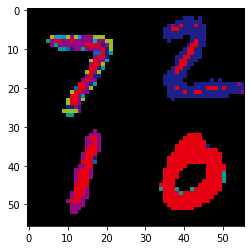

epoch=1 test_accuracy=0.803774 test_loss=5534.797942 train_accuracy=0.803336 train_loss=5540.795284


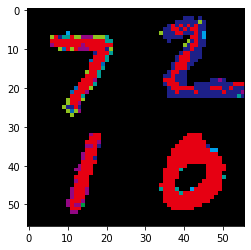

epoch=1 test_accuracy=0.804243 test_loss=5525.014104 train_accuracy=0.804053 train_loss=5531.001139


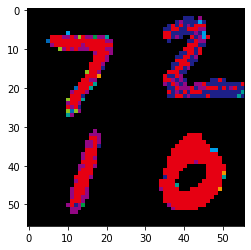

epoch=1 test_accuracy=0.802303 test_loss=5537.255198 train_accuracy=0.802248 train_loss=5542.883582


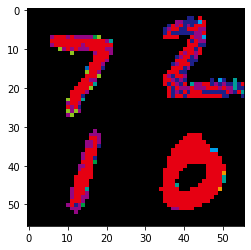

KeyboardInterrupt: 

In [33]:
main_net.send_command('parameter_lock false')

for _ in range(8):
    runner.fitting(td, epoch_size=1, mini_batch_size=32, file_write=False, file_read=False)
    save_all_model('last2')
    plot_image(main_net, td)